## Introduction

In 2018, the e-commerce site Rakuten ran a public data challenge that asked data scientists to develop a model to classify products given a text description of that product. This notebook begins to address this challenge through some initial data and problem exploration. Included in this work is the initial data analysis and discussion of performance metrics.

While this work is derived from many sources, many of the methods and approaches were inspired by the scikit learn tutorial on working with text data: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
import seaborn as sns
from sklearn.preprocessing import normalize
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

## Data Analysis

### Training Data

The training data, data used to train the machine leaning model, consists of 800,000 records. Each record has only two fields: a description of the product and the product's category. The fields are both strings. The following subsections take a closer look at the labels (product category) and features (product description). Minor cleaning checked that there were no invalid (np.nan or None) values in either the description or category fields.

In [2]:
#load data
train_data = pd.read_csv('https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-train.tsv', header=None, names=['description', 'cat_full'], sep='\t', )

#print some basic information about data
print('Number of rows: ', train_data.shape[0])
print('Number of columns: ', train_data.shape[1])

#look at the data
train_data.head()

Number of rows:  800000
Number of columns:  2


,description,cat_full
0,Replacement Viewsonic VG710 LCD Monitor 48Watt...,3292>114>1231
1,HP COMPAQ Pavilion DV6-1410EZ 4400mAh 48Wh 6 C...,3292>1370>4767>3975>1420
2,Bonjour,2296>3597>2989
3,Two Pack 6V 12Ah Eaton POWERRITE PRO II 2400 ...,3292>114>1231
4,Generations Small Side Table White,4015>3636>1319>1409>3606


In [3]:
train_data['cat_1'] = train_data['cat_full'].apply(lambda x: x.split('>')[0])
train_data['cat_2'] = train_data['cat_full'].apply(lambda x: x.split('>')[1] if (len(x.split('>'))>1) else np.nan)

In [4]:
#basic cleaning, remove any rows that don't have values in the decsription or cat_1 fields (leaving those with
#missing cat_2 for now)
print('Number of rows before cleaning: ', train_data.shape[0])
train_data.dropna(subset=['description','cat_1'], inplace=True)
print('Number of rows after cleaning: ', train_data.shape[0])

Number of rows before cleaning:  800000
Number of rows after cleaning:  800000


In [5]:
#making a function to perform all the actions shown above for better repetition (and use in other notebooks)
def import_format_data(this_url):
    """
    Loads data from provided url into Pandas dataframe,
    breaks out columns for different category levels and
    does basic data cleaning. Basic data cleaning here involves
    dropping rows with empty description or first level category labels.
    Note that it does not drop rows with empty fields for categories
    after the first level as the number of levels assigned is variable.
    
    args:
    this_url (str): URL of dataset
    
    returns:
    pandas df of processed data
    
    """
    
    this_data = pd.read_csv(this_url, header=0, names=['description', 'cat_full'], sep='\t')
    this_data['cat_1'] = this_data['cat_full'].apply(lambda x: x.split('>')[0])
    this_data['cat_2'] = this_data['cat_full'].apply(lambda x: x.split('>')[1] if (len(x.split('>'))>1) else np.nan)
    this_data.dropna(subset=['description','cat_1'], inplace=True)
    
    return this_data

#### Labels

The category field is ultimately the labels. The categories are hierarchical with each level separated by a ">" character. Not all labels consist of the same number of levels. Number of category levels range from 1 to 8 with a mean of 4. To simplify this work, we will focus on classification of the first two levels only and leave further classification to future work. There are 14 unique first level categories and 109 unique second level categories. Further there are 109 unique first+second level categories, meaning there are no shared second level categories with first level categories (e.g. if A>1 and B>2 are categories, "1" always mapped back to "A" and 2 always mapped back to "B").

Finally, we take a look at how balanced the data is for the first level category. It is not a very balanced dataset, with 2/14 of the first level categories composing more than 50% of the dataset. This may have implications on certain classifier performance, perhaps showing overwhelming preference to classifying those more prevalent categories.

Minimum number of categories:  1
Maximum number of categories:  8
Mean number of categories:  4.0131475


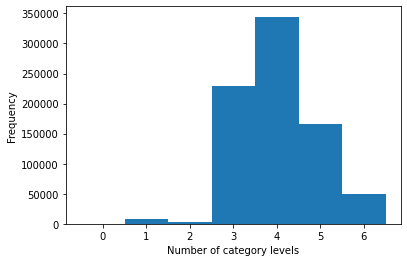

In [6]:
#looking at the distribution for teh category mappings
num_categories = train_data['cat_full'].apply(lambda x: len(x.split('>')))
print('Minimum number of categories: ', min(num_categories))
print('Maximum number of categories: ', max(num_categories))
print('Mean number of categories: ', np.mean(num_categories))


plt.hist(num_categories, align='left', bins=[x for x in range(max(num_categories))])
plt.xlabel('Number of category levels')
plt.ylabel('Frequency')
plt.show()

In [7]:
#look at numer of categories
print('Number of first level distinct categories: ', len(train_data['cat_1'].unique()))
print('Number of second level distinct categories: ', len(train_data['cat_2'].unique()))
#double checking there are no second level category mappings that are shared between first levels
#(e.g. 1>a and 2>a)
print('Number of first+second level distinct categories: ', len(train_data.groupby(['cat_1', 'cat_2'])))

Number of first level distinct categories:  14
Number of second level distinct categories:  109
Number of first+second level distinct categories:  109


In [8]:
#Looking at how balanaced the training set is
train_data.groupby('cat_1').apply(len)/len(train_data['cat_1'])

cat_1
1208    0.001288
1395    0.023559
1608    0.106942
2075    0.025108
2199    0.120892
2296    0.035515
3093    0.006372
3292    0.251181
3625    0.036946
3730    0.010141
4015    0.335369
4238    0.029411
4564    0.007060
92      0.010215
dtype: float64

#### Features

The description field will provide the basis for the feature(s) in our machine learning model. Each description is a short collection of "words" any about the product. Words here are actually tokens, defined by the scikit learn toolkit tokenizer, which is basically smaller groups of characters identifiable meaning (usually words). The entry descriptions' length range from 0 to 52 words with a mean of 10.6 and a standard deviation of 4.7. This led to the decision to use a bag of words model, a model whereby words and their frequency are the system's features. There are often few enough words in the descriptions, that the machine learning model will likely be classifying categories from previously encountered words.


The scikit learn tokenizer is used convert the description text into tokens. We first apply this to a small sample set to gain a better understanding of how the tokenizer constructs the features. We see that the tokenizer works by breaking up all the tokens in all n training data points into m tokens. Then, it constructs an nxm matrix which is the count of every possible token in each training data point. You can normalize beyond simple word counts to account for super common words among and within different entries using TF-IDF (term frequency times inverse document frequency). Each of the n training points is so short however, that it's unclear how helpful this normalization would be and is thus left to future work.

After gaining some understanding of how the tokenizer functions, we broadened the analysis to look at the entire tokenized training set. Without any further data processing, the training set contains 427,297 total tokens. Looking at the token frequency across the training set, we see that tokens had a mean count of ~20 tokens with a standard deviation of ~510 tokens, meaning some high frequency words are much higher frequency than others and skewing that standard deviation pretty high. There are a couple potential data processing measures we could take here such as:

- Removing stop words: By removing common words in the English language, such as "the", we may be able to reduce and enrich the feature space.
- Using n-grams: Small groups of tokens, rather than single tokens, may contain more context. For example, we show that "black" is a high frequency word. But using pairs of words like "black beans" and "black notebook" we may give the features more context.
- Stemming/Lemmatizing: Grouping words together with similar meanings would help reduce the size of and enrich the feature space. An example of stemming/lemmatizing would be mapping "battery" and "batteries" to the same token.
- Translation: A peek at the tokens below reveals that there are some entries with non-English words. Performing a translation operation to English such that all entries are the same language would help build a better training set.

The analysis below explores removing stop words and using n-grams. While we believe stemming/lemmatizing and translation would be good data processing steps, we are leaving this to future work.

Finally, we did detect 11 test data entries where the tokenizer identified 0 tokens. 10/11 of those entries map to the same category so you could consider a "no data is data" approach, but I hypothesize it will more likely lead to overfitting and would best be removed.


In [9]:
#Stats of number of "words" in each description field
word_counter = CountVectorizer()
word_counter.fit(train_data['description'])
train_x = word_counter.transform(train_data['description'])

num_words_per_record = train_x.sum(axis=1)
print('Description Length Statistics: ')
print('Min: ', np.min(num_words_per_record))
print('Max: ', np.max(num_words_per_record))
print('Mean: ', np.mean(num_words_per_record))
print('Std. Dev.: ', np.std(num_words_per_record))

Description Length Statistics: 
Min:  0
Max:  52
Mean:  10.60846875
Std. Dev.:  4.682643167087735


In [10]:
#looking at the feature (bag of words of description field) for TWO descriptions
vectorizer = CountVectorizer()
print('Sample String: ')
sample_data = train_data.iloc[0:2]['description']
print(sample_data)

#create a dictionary from the whole trainign set
vectorizer.fit_transform(sample_data)
vocab_full =  vectorizer.get_feature_names()
vectorizer = CountVectorizer(vocabulary=vocab_full)
bow_counts = sample_data.apply(lambda x: vectorizer.fit_transform([x]))

print('')
print('Features: ')
print(vectorizer.get_feature_names())

print('')
print('Number of Occurences: ')
print(bow_counts.apply(lambda x: x.toarray()[0]))

Sample String: 
0    Replacement Viewsonic VG710 LCD Monitor 48Watt...
1    HP COMPAQ Pavilion DV6-1410EZ 4400mAh 48Wh 6 C...
Name: description, dtype: object

Features: 
['10', '12v', '1410ez', '4400mah', '48watt', '48wh', '4a', '8v', 'ac', 'adapter', 'battery', 'black', 'cell', 'compaq', 'compatible', 'dv6', 'hp', 'ion', 'lcd', 'li', 'monitor', 'pavilion', 'replacement', 'vg710', 'viewsonic']

Number of Occurences: 
0    [0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, ...
1    [1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, ...
Name: description, dtype: object


In [11]:
#Broadening analysis to whole training set

def quick_feature_analysis(feature=train_data['description'], tok_kwargs={}):
    vectorizer = CountVectorizer(**tok_kwargs)
    vectorizer.fit(feature)
    train_x = vectorizer.transform(feature)
    print('Number of features: ', train_x.shape[1])

    #What are some high frequency words?
    top_i = 10

    total_occurences = zip(vectorizer.get_feature_names(), train_x.sum(axis=0).tolist()[0])
    total_occurences_sorted = sorted(total_occurences, key=lambda x: -x[1])
    print(' ')
    print('Highest frequency words: ')
    print(total_occurences_sorted[0:top_i])

    print(' ')
    print('Lowest frequency words: ')
    print(total_occurences_sorted[-top_i:])

    print(' ')
    print('Basic Statistics of Word Frequencies: ')
    word_freq = train_x.sum(axis=0).tolist()[0]
    print('Mean: ', np.mean(word_freq))
    print('Standard Deviation: ', np.std(word_freq))
    print('Min: ', np.min(word_freq), ', Number of occurences: ', len(np.argwhere(word_freq==np.min(word_freq))))
    print('Max: ', np.max(word_freq))
    
quick_feature_analysis()


Number of features:  427297
 
Highest frequency words: 
[('for', 165031), ('replacement', 91313), ('pack', 74865), ('black', 64110), ('battery', 55975), ('cover', 55047), ('in', 53520), ('skin', 50501), ('and', 46959), ('decal', 43758)]
 
Lowest frequency words: 
[('µdimm', 1), ('â³', 1), ('çelebration', 1), ('égales', 1), ('élan', 1), ('épais', 1), ('étagère', 1), ('üsküdar', 1), ('œme', 1), ('ﾠb', 1)]
 
Basic Statistics of Word Frequencies: 
Mean:  19.861536589304396
Standard Deviation:  509.9616573544085
Min:  1 , Number of occurences:  290634
Max:  165031


In [12]:
#What if we removed stop words?
quick_feature_analysis(tok_kwargs={'stop_words':'english'})

Number of features:  427019
 
Highest frequency words: 
[('replacement', 91313), ('pack', 74865), ('black', 64110), ('battery', 55975), ('cover', 55047), ('skin', 50501), ('decal', 43758), ('protective', 43434), ('filter', 40792), ('vinyl', 39550)]
 
Lowest frequency words: 
[('µdimm', 1), ('â³', 1), ('çelebration', 1), ('égales', 1), ('élan', 1), ('épais', 1), ('étagère', 1), ('üsküdar', 1), ('œme', 1), ('ﾠb', 1)]
 
Basic Statistics of Word Frequencies: 
Mean:  18.557822954013755
Standard Deviation:  417.8405487963014
Min:  1 , Number of occurences:  290622
Max:  91313


In [13]:
#What if we used n-grams?
quick_feature_analysis(tok_kwargs={'ngram_range': (1,2)})

Number of features:  2480461
 
Highest frequency words: 
[('for', 165031), ('replacement', 91313), ('pack', 74865), ('black', 64110), ('battery', 55975), ('cover', 55047), ('in', 53520), ('skin', 50501), ('and', 46959), ('decal', 43758)]
 
Lowest frequency words: 
[('œme salon', 1), ('šâ žâ', 1), ('šã premium', 1), ('šã pãƒæ', 1), ('šã re', 1), ('šã â³', 1), ('šã â¾ãƒæ', 1), ('žâ ãƒæ', 1), ('ﾠb', 1), ('ﾠb battery', 1)]
 
Basic Statistics of Word Frequencies: 
Mean:  6.520385121959184
Standard Deviation:  227.16310240064493
Min:  1 , Number of occurences:  1792252
Max:  165031


In [14]:
print('Number of entries with no decscription: ', len(np.argwhere(num_words_per_record==0)))

print(' ')
print('Entries with empty features: ')
print(train_data.iloc[[i for i in np.argwhere(num_words_per_record==0)[:,0]]])

Number of entries with no decscription:  11
 
Entries with empty features: 
       description         cat_full cat_1 cat_2
58845        3 & 4    2296>3597>689  2296  3597
161182     1-2-3-4    2296>3597>689  2296  3597
240920           R   2296>3706>2852  2296  3706
249402         3.0   2296>3597>2002  2296  3597
485492         S'u    2296>3597>689  2296  3597
528822         2.0    2296>3597>689  2296  3597
587832     4, 5, 6   2296>2435>1941  2296  2435
593957           S   2296>3706>1175  2296  3706
615731         $O$    2296>3597>689  2296  3597
707056          N+  3292>49>189>398  3292    49
713429       X O K   2296>3597>3083  2296  3597


### Test Data

The test data contains 200,000 entries with the same fields as the training data. We've loaded the dataset and performed the same preprocessing here, but have intentionally limited exploration to avoid overfitting. A quick look at the first category label distribution shows that while it also seems to be unbalanced, it appears to be unbalanced in the same manner as the training data.

In [15]:
test_data = import_format_data('https://github.com/up-lab/rakuten-data-challenge/raw/master/rdc-catalog-test.tsv')
print('Number of rows: ', test_data.shape[0])
test_data.head()


Number of rows:  200000


,description,cat_full,cat_1,cat_2
0,Sterling Silver Dangle Ball Earrings w/ Brilli...,1608>2320>2173>3813,1608,2320
1,ALTERNATOR FREIGHTLINER FL FLC 112 120 FLD 112...,2199>4592>12,2199,4592
2,Disc Brake Rotor-Advanced Technology Rear Rayb...,2199>4592>12,2199,4592
3,Coquette Neon Pink Ruffle Babydoll 7035 Neon P...,1608>4269>3031>1221,1608,4269
4,12V 7Ah (SPS Brand) APC NS3000RMT3U Replacemen...,3292>114>1231,3292,114


In [16]:
#Looking at how balanaced the test set is
test_data.groupby('cat_1').apply(len)/len(test_data['cat_1'])

cat_1
1208    0.000605
1395    0.020385
1608    0.105870
2075    0.023325
2199    0.127690
2296    0.041095
3093    0.006155
3292    0.250175
3625    0.039045
3730    0.010055
4015    0.330875
4238    0.028400
4564    0.005855
92      0.010470
dtype: float64

## Performance Metrics

The most straightforward metric is of course accuracy. Accuracy simply tells us the percentage that the classifier predicts the correct label.

An evaluation tool we will look at here is a confusion matrix (at least for the first level of categorization). The confusion matrix is a grid showing number/percentage of each predicted labels vs the actual labels. This may be advantageous for debugging purposes (e.g. are there two classes that are often confused for one another?).

Other performance metrics should be considered depending on system design intentions. If this is a human-in-the-loop system and the accuracy is only ok, I would recommend another performance metric here that measures how well the classifier understands its' ability to predict the output. In other words, how accurate is the classifiers' prediction probability? One example of this type of metric would be the Brier score. In this system, if the prediction probabilities are determined to be reliable, a confidence threshold could be set and all predictions whose probability is below that threshold would be flagged for human validation and feedback. This type of metric was not evaluated here but is strongly recommended after further use case review with stakeholders.

In [17]:
#test for accuracy
def display_performance(classifier, test_x, test_y, train_x=[], train_y=[]):
    """
    Prints accuracy and confusion matrix for specified classifier and test set.
    Displays the confusion matrix. 
    
    """

    if (train_x.shape[0]>0) & (train_y.shape[0]>0):
        train_accuracy = classifier.score(train_x, train_y)
        print('Overall Training Set Accuracy: ', train_accuracy)
        cv_scores = cross_val_score(classifier, train_x, train_y, cv=5)
        print('Cross-validated Training Set Accuracy: {:.2f} +/- {:.2f}'.format(np.mean(cv_scores), np.std(cv_scores)))
    
    accuracy = classifier.score(test_x, test_y)
    
    print('Test Set Accuracy: ', accuracy)
    
    predictions = classifier.predict(test_x)
    num_labels = len(classifier.classes_)
    cf_matrix = np.zeros((num_labels, num_labels))
    labels = np.unique(test_y)
    
    for i, prediction in enumerate(predictions):
        label_actual = test_y[i]
        label_actual_idx = np.argwhere(labels==label_actual)[0]
        predict_label_idx = np.argwhere(labels==prediction)[0]
        cf_matrix[label_actual_idx, predict_label_idx] += 1
        cf_matrix_norm = normalize(cf_matrix, axis=1, norm='l1')

    sns.heatmap(cf_matrix_norm, xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    